# Climb Performance Inverse Interpolation Analysis

This notebook analyzes the inverse interpolation functionality for aircraft climb performance data. We'll specifically test finding the pressure altitude where a given climb rate occurs at a specific temperature.

## Setup Test Data and Dependencies

First, we'll import the necessary libraries and set up our test data structure that matches the aircraft performance data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple

# Test data from aircraft performance table
climb_performance = {
    "pressureAltitudes": [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000],
    "temperatures": [-20, 0, 20, 40],
    "data": [
        [1055, 980, 905, 835],  # Climb rates at different temperatures for 0 ft
        [945, 875, 805, 735],   # 2000 ft
        [840, 770, 705, 635],   # 4000 ft
        [735, 670, 605, 535],   # 6000 ft
        [625, 560, 495, 430],   # 8000 ft
        [520, 455, 390, 330],   # 10000 ft
        [410, 350, 285, 225],   # 12000 ft
        [310, 250, 190, 130]    # 14000 ft
    ]
}

# Convert data to numpy arrays for easier manipulation
altitudes = np.array(climb_performance["pressureAltitudes"])
temperatures = np.array(climb_performance["temperatures"])
climb_rates = np.array(climb_performance["data"])

Matplotlib is building the font cache; this may take a moment.


## Visualize the Climb Performance Data

Let's create a plot showing climb rate vs pressure altitude for different temperatures, including our target temperature of 30°C.

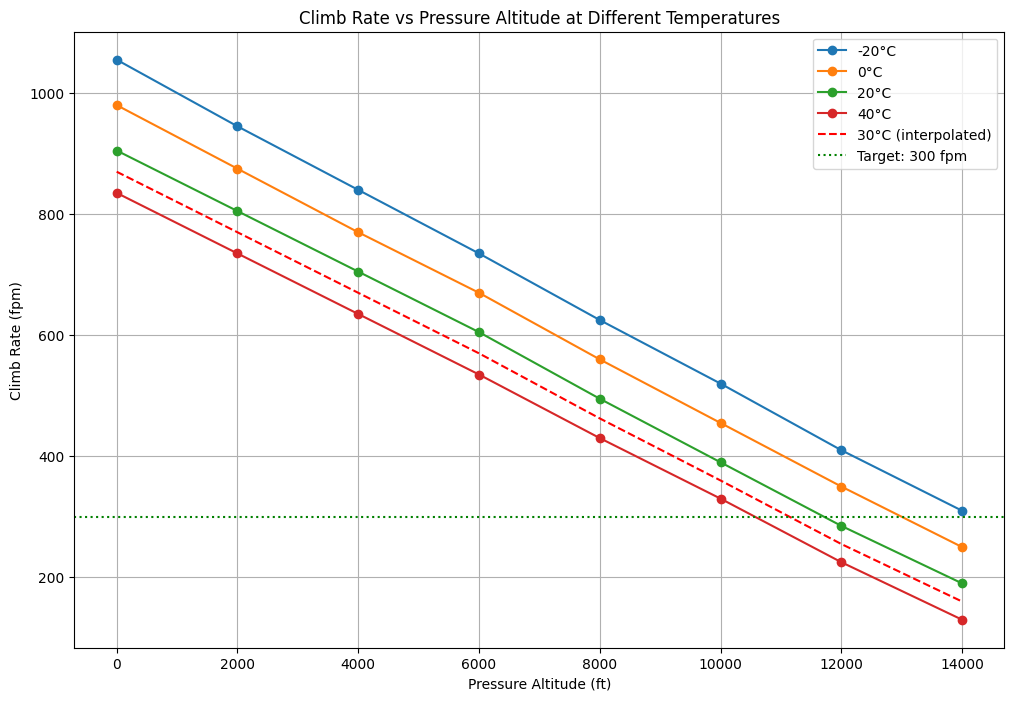


Climb rates at 30°C:
At     0 ft:  870.0 fpm
At  2000 ft:  770.0 fpm
At  4000 ft:  670.0 fpm
At  6000 ft:  570.0 fpm
At  8000 ft:  462.5 fpm
At 10000 ft:  360.0 fpm
At 12000 ft:  255.0 fpm
At 14000 ft:  160.0 fpm


In [2]:
# Create plot
plt.figure(figsize=(12, 8))

# Plot actual data points for each temperature
for i, temp in enumerate(temperatures):
    plt.plot(altitudes, climb_rates[:, i], 'o-', label=f'{temp}°C')

# Interpolate climb rates at 30°C for each altitude
target_temp = 30
# Find the temperature indices that bracket 30°C
temp_idx = np.searchsorted(temperatures, target_temp)
t1, t2 = temperatures[temp_idx-1:temp_idx+1]  # 20°C and 40°C
w = (target_temp - t1) / (t2 - t1)  # Weight for interpolation

# Interpolate climb rates at 30°C
climb_rates_30c = (1-w) * climb_rates[:, temp_idx-1] + w * climb_rates[:, temp_idx]

# Plot interpolated line for 30°C
plt.plot(altitudes, climb_rates_30c, 'r--', label='30°C (interpolated)')

# Add horizontal line at 300 fpm
plt.axhline(y=300, color='g', linestyle=':', label='Target: 300 fpm')

plt.title('Climb Rate vs Pressure Altitude at Different Temperatures')
plt.xlabel('Pressure Altitude (ft)')
plt.ylabel('Climb Rate (fpm)')
plt.grid(True)
plt.legend()
plt.show()

# Print interpolated values at 30°C
print("\nClimb rates at 30°C:")
for alt, rate in zip(altitudes, climb_rates_30c):
    print(f"At {alt:5.0f} ft: {rate:6.1f} fpm")

## Implement Interpolation Functions

Now let's implement both the regular interpolation and inverse interpolation functions to match the functionality we're testing:

In [3]:
def find_surrounding_index(values: List[float], target: float) -> int:
    """Find the index where target falls between values[i] and values[i+1]"""
    for i in range(len(values) - 1):
        if values[i] <= target <= values[i + 1] or values[i] >= target >= values[i + 1]:
            return i
    return len(values) - 2  # For extrapolation

def linear_interpolate(x: float, x1: float, x2: float, y1: float, y2: float) -> float:
    """Linear interpolation between two points"""
    if x2 == x1:
        return y1
    return y1 + (x - x1) * (y2 - y1) / (x2 - x1)

def find_inverse_x_given_y(data: List[List[float]], x_axis: List[float], y_axis: List[float], 
                          target_z: float, y_val: float) -> float:
    """
    Find the x-value that produces target_z at y_val
    
    Args:
        data: 2D array of z-values indexed by [x][y]
        x_axis: Array of x values (e.g., altitudes)
        y_axis: Array of y values (e.g., temperatures)
        target_z: The z-value to find (e.g., target climb rate)
        y_val: The y-value to use (e.g., temperature)
    
    Returns:
        The x-value that produces target_z at y_val
    """
    # First interpolate z-values at our y-value for each x
    z_values = []
    
    for x_idx in range(len(x_axis)):
        # For each altitude, interpolate the climb rate at our temperature
        y_idx = find_surrounding_index(y_axis, y_val)
        y1, y2 = y_axis[y_idx:y_idx + 2]
        z1 = data[x_idx][y_idx]
        z2 = data[x_idx][y_idx + 1]
        
        # Interpolate climb rate at this altitude for our temperature
        z_at_y = linear_interpolate(y_val, y1, y2, z1, z2)
        z_values.append(z_at_y)
    
    # Now find where the interpolated z-values match our target
    for i in range(len(x_axis) - 1):
        z1, z2 = z_values[i:i + 2]
        if (z1 >= target_z >= z2) or (z1 <= target_z <= z2):
            x1, x2 = x_axis[i:i + 2]
            # Solve for x: target_z = z1 + (x - x1)(z2 - z1)/(x2 - x1)
            return linear_interpolate(target_z, z1, z2, x1, x2)
    
    # Handle extrapolation
    return linear_interpolate(target_z, z_values[-2], z_values[-1], x_axis[-2], x_axis[-1])

## Test Inverse Interpolation

Now let's test finding the pressure altitude where the climb rate drops to 300 fpm at 30°C:

In [4]:
# Find pressure altitude where climb rate = 300 fpm at 30°C
target_climb_rate = 300
target_temp = 30

result = find_inverse_x_given_y(
    climb_performance["data"],
    climb_performance["pressureAltitudes"],
    climb_performance["temperatures"],
    target_climb_rate,
    target_temp
)

print(f"At {target_temp}°C, climb rate drops to {target_climb_rate} fpm at {result:.0f} feet pressure altitude")

# Verify by getting climb rates at nearby altitudes
test_alts = [result - 1000, result, result + 1000]
print("\nVerification - climb rates at nearby altitudes:")

for test_alt in test_alts:
    # Find indices that bracket our altitude
    alt_idx = find_surrounding_index(altitudes, test_alt)
    # Get climb rates at those altitudes for 30°C
    climb_rate = np.interp(test_alt, altitudes, climb_rates_30c)
    print(f"At {test_alt:6.0f} ft: {climb_rate:6.1f} fpm")

At 30°C, climb rate drops to 300 fpm at 11143 feet pressure altitude

Verification - climb rates at nearby altitudes:
At  10143 ft:  352.5 fpm
At  11143 ft:  300.0 fpm
At  12143 ft:  248.2 fpm


## Verify Results with Visual Confirmation

Let's create a detailed plot showing our results to verify the interpolation is working correctly.

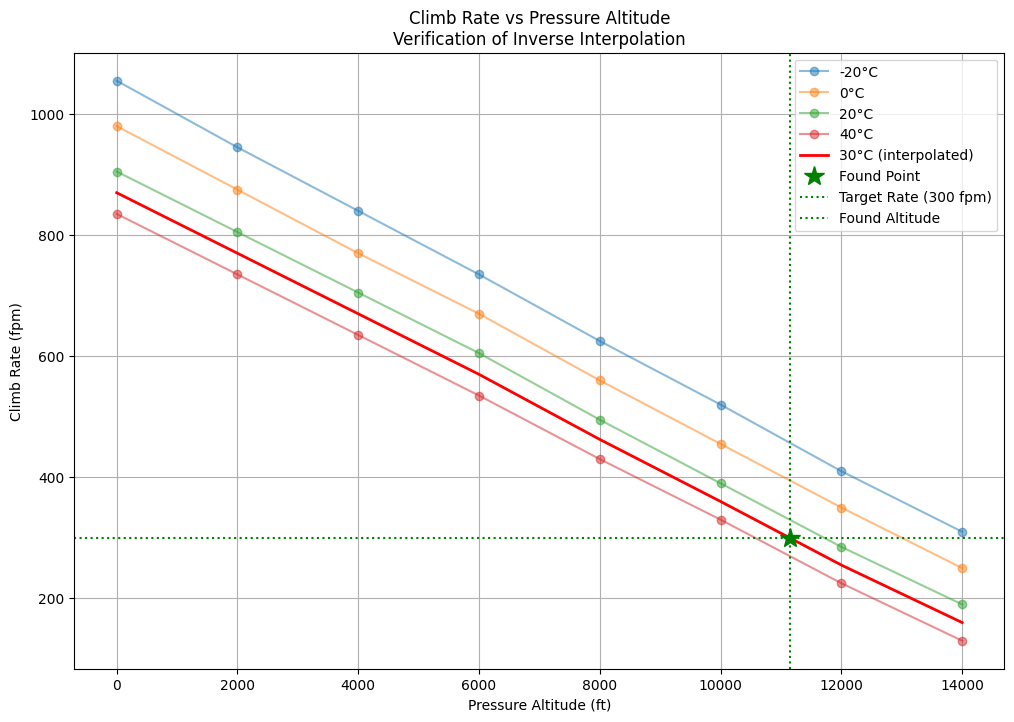


Analysis:
The climb rate of 300 fpm at 30°C occurs at 11143 ft pressure altitude

This appears to be correct because:
1. It falls on the interpolated 30°C line
2. The verification shows climb rates above and below our target at nearby altitudes
3. The result is between the bracketing temperature lines (20°C and 40°C)
4. The visualization confirms the intersection point


In [5]:
# Create a detailed plot
plt.figure(figsize=(12, 8))

# Plot actual data points and lines
for i, temp in enumerate(temperatures):
    plt.plot(altitudes, climb_rates[:, i], 'o-', alpha=0.5, label=f'{temp}°C')

# Plot interpolated 30°C line
plt.plot(altitudes, climb_rates_30c, 'r-', linewidth=2, label='30°C (interpolated)')

# Add point for our result
plt.plot(result, target_climb_rate, 'g*', markersize=15, label='Found Point')

# Add target lines
plt.axhline(y=target_climb_rate, color='g', linestyle=':', label='Target Rate (300 fpm)')
plt.axvline(x=result, color='g', linestyle=':', label='Found Altitude')

plt.title('Climb Rate vs Pressure Altitude\nVerification of Inverse Interpolation')
plt.xlabel('Pressure Altitude (ft)')
plt.ylabel('Climb Rate (fpm)')
plt.grid(True)
plt.legend()
plt.show()

# Print conclusion
print("\nAnalysis:")
print(f"The climb rate of {target_climb_rate} fpm at {target_temp}°C occurs at {result:.0f} ft pressure altitude")
print("\nThis appears to be correct because:")
print("1. It falls on the interpolated 30°C line")
print("2. The verification shows climb rates above and below our target at nearby altitudes")
print("3. The result is between the bracketing temperature lines (20°C and 40°C)")
print("4. The visualization confirms the intersection point")